In [66]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Created on Tue Mar 14 14:47:58 2023

@author: mariapopovic
"""

from numpy import array, exp, append, linspace, log, average, around, arange, sqrt, random, inf
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from math import erf, pi, erfc
from scipy.special import erfinv
from scipy.stats import norm
from scipy.integrate import quad

class optimal_quantizers(object):
    
    def __init__(self,p):
        
        self.mu = p[0]
        self.sigma = p[1]
        
        n = [1,2,3,4,5,6,7,8,9,10] # This is the number of qubits needed to encode 2^n bins on a quantum comp
        self.number_bins_list = []
        
        index = 0
        for el in n:
            self.number_bins_list.append(2**int(el)) # Possible numbers of bins
            index = index + 1
        
        ##### EQUIMASS KNOTS #####
        self.probabilities_equimass = [[]]*len(self.number_bins_list)
        self.knots_equimass = [] # Equimass knots
        self.cdf_equimass_rightbound = []
        self.y_equimass = [] # Equimass quantizers
        
        ##### STATIONARY KNOTS #####
        self.probabilities_stationary = [[]]*len(self.number_bins_list)
        self.knots_stationary= [] 
        self.cdf_stationary_rightbound = []
        self.y_stationary = [] 

        ##### LINEAR KNOTS #####
        self.probabilities_linear = [[]]*len(self.number_bins_list)
        self.knots_linear = [] 
        self.cdf_linear_rightbound = [[]]*len(self.number_bins_list)
        self.y_linear = [] 

        
        
    ############################# EQUIMASS ###########################################
    
    # Define equimass knots and their probabilitites
    def create_equimass_knots(self):
        
        cell_bounds_equimass = [[]]*len(self.number_bins_list)
        
        def inverse_cdf(y):
            return sqrt(2)*erfinv(2*y - 1)
        
        # Probabilities for equi-mass quantizer, same for every knot

        for index_bins in range(0,len(self.number_bins_list)):
    
            el = self.number_bins_list[index_bins]
            self.probabilities_equimass[index_bins] = append(self.probabilities_equimass[index_bins], [1/el]*el)
    

        for n in self.number_bins_list:
    
            gammas_equimass = []
    
            for i in range(1, n + 1):
        
                num_i = exp(-((inverse_cdf((i-1)/n))**2)/2) - exp(-((inverse_cdf(i/n))**2)/2)
                gamma_i = (n/(sqrt(2*pi)))*(num_i)
                gammas_equimass.append(gamma_i*self.sigma + self.mu)
     
            self.knots_equimass.append(gammas_equimass)

    
        # Create bounds for cells

        for index_bins in range(0,len(self.number_bins_list)):
    
            n = self.number_bins_list[index_bins]
       
            for i in range(0, n+1):
                cell_bounds_equimass[index_bins] = append(cell_bounds_equimass[index_bins],inverse_cdf(i/n)*self.sigma + self.mu)


        # Define the cumulative distribution function from the right extreme of each cell

        for index_bins in range(0,len(self.number_bins_list)):
            self.cdf_equimass_rightbound.append(norm.cdf(cell_bounds_equimass[index_bins][1:]))
    
        # Round last element to = 1

        for index_bins in range(0,len(self.number_bins_list)):
    
            tmp = self.cdf_equimass_rightbound[index_bins][:-1]
            self.cdf_equimass_rightbound[index_bins] = append(tmp,round(self.cdf_equimass_rightbound[index_bins][-1]))

    # Extract one equimass quantizer according to their probability distribution
    def equimass_quantizer(self):
        
        self.y_equimass = []
        
        u = random.uniform(0,1)
        
        for index_bins in range(0,len(self.number_bins_list)):
        
            index2 = 0
    
            while self.cdf_equimass_rightbound[index_bins][index2] < u:
                index2 = index2 + 1

            self.y_equimass.append(self.knots_equimass[index_bins][index2])
            
    ############################# STATIONARY ###########################################
    
    # Define stationary knots and their probabilitites
    def create_stationary_knots(self):
        
        # Set of equations to solve for stationary knots
        
        def probabilities(a, b):
        
            return quad(lambda x: (1/(sqrt(2*pi)*self.sigma))*exp(-(((x - self.mu)/self.sigma)**2)/2), a, b)[0]
        

        def prob_equations_stat(g0,g1,g2):
            #p_i
            return 0.5*(erf((g2 + g1)/(2*sqrt(2))) - erf((g0 + g1)/(2*sqrt(2))))

        
        def knot_equations_stat(g0,g1,g2):
            #gamma_i
            den = (sqrt(2*pi)*prob_equations_stat(g0,g1,g2))
            den -= 1e-15
            
            return (exp(-((g0 + g1)**2)/8) - exp(-((g2 + g1)**2)/8))/den
        
        # Solve equations for knots and corresponding probabilities
        for index_bins in range(0,len(self.number_bins_list)):
        
            n = int(self.number_bins_list[index_bins]/2)
           
            def equations_stationary_knots(p):
    
                eq_list = [p[0] - knot_equations_stat(-p[0],p[0],p[1])]
    
                for index in range(1,n-1):
        
                    eq_list.append(p[index] - knot_equations_stat(p[index-1],p[index],p[index + 1]))
    
                eq_list.append(p[n - 1] - knot_equations_stat(p[n - 2],p[n - 1],inf))
        
                return eq_list     
            
            start_points = []
            j = 1
            while j <= n:
                start_points.append(3*j/n)
                j = j + 1
    
            # n = 1
        
            def eq1(p):
                
                return p - knot_equations_stat(0,p,inf)
            
            if n == 1:
                gammas_stationary = fsolve(eq1, 3)

            else:
                gammas_stationary = fsolve(equations_stationary_knots, start_points)
                
                
            
            tmp = append(- gammas_stationary[::-1],gammas_stationary)
            
            # If mean is not 0 and variance is not 1
            for index in range(0, len(tmp)):
                
                tmp[index] =  tmp[index]*self.sigma + self.mu

            self.knots_stationary.append(tmp)
         
        # Create cells
            
        cell_bounds_stationary = []
        
        for index_bins in range(0,len(self.number_bins_list)):
    
            
            cell_bounds_stationary.append([-inf])
            
            for index2 in range(1,len(self.knots_stationary[index_bins])):
    
                cell_bounds_stationary[index_bins].append((self.knots_stationary[index_bins][index2] + self.knots_stationary[index_bins][index2 - 1])/2)
        
            # Append extreme right bound
    
            cell_bounds_stationary[index_bins].append(inf)
        
    
            # Define the cumulative distribution function from the right extreme of each cell

            self.cdf_stationary_rightbound.append(norm.cdf(cell_bounds_stationary[index_bins][1:]))

            # Round last element to = 1
    
            tmp = self.cdf_stationary_rightbound[index_bins][:-1]
            self.cdf_stationary_rightbound[index_bins] = append(tmp,round(self.cdf_stationary_rightbound[index_bins][-1]))
       
    # Create probabilities
    
        for index_bins in range(0,len(self.number_bins_list)):
            
            for index in range(0,len(cell_bounds_stationary[index_bins]) - 1):
                new_prob = probabilities(cell_bounds_stationary[index_bins][index], cell_bounds_stationary[index_bins][index + 1])
                self.probabilities_stationary[index_bins] = append(self.probabilities_stationary[index_bins], new_prob )
        

    # Extract one stationary quantizer according to their probability distribution
    def stationary_quantizer(self):
        
        self.y_stationary = []
        
        u = random.uniform(0,1)
        
        for index_bins in range(0,len(self.number_bins_list)):
        
            index2 = 0
    
            while self.cdf_stationary_rightbound[index_bins][index2] < u:
                index2 = index2 + 1

            self.y_stationary.append(self.knots_stationary[index_bins][index2])
            
    ############################# LINEAR ###########################################

    # Define linear knots and their probabilitites
    def create_linear_knots(self):
        
        alpha_list = []
        cell_bounds_linear = [[]]*len(self.number_bins_list)
        
        def probabilities(a, b):
        
            return quad(lambda x: (1/(sqrt(2*pi)*self.sigma))*exp(-(((x - self.mu)/self.sigma)**2)/2), a, b)[0]
           
        
        for index_bin in range(0,len(self.number_bins_list)):
    
            n = self.number_bins_list[index_bin]/2

        
            def equations_optimal_linear(alpha):
        
        
                def first_integral(n,j,alpha):
    
                    term1 = 2*n*(exp(-(((j-1)**2)*(alpha**2))/(2*(n**2))) - exp(-((j**2)*(alpha**2))/(2*(n**2))))
    
                    term2 = (2*j - 1)*alpha*sqrt(pi/2)*(erf(((j-1)*alpha)/(sqrt(2)*n)) - erf((j*alpha)/(sqrt(2)*n)))

                    return -((2*j - 1)/(4*n*sqrt(2*pi)))*(term1 + term2)

                def second_integral(n,alpha):
    
                    term1 = -2*sqrt(2/pi)*exp(-(((n-1)**2)*(alpha**2))/(2*(n**2)))
    
                    term2 = (2*n - 1)*(alpha/n)*erfc(((n-1)*alpha)/(sqrt(2)*n))
    
                    return (1/8)*(2*n - 1)*(term1 + term2)

                def first_integral_sum(n,alpha):
    
                    sum_index = 0
                    j = 1
    
                    while j < n:
                        sum_index = sum_index + first_integral(n,j,alpha)
                        j = j + 1
    
                    return sum_index

                return first_integral_sum(n,alpha) + second_integral(n,alpha)

            a = fsolve(equations_optimal_linear,1)
            alpha_list.append(a)
    
            start = -a + (a/(2*n)) # for even quantizers
            h = a/n
            j = 1
            gammas_linear = []
            while j <= n:
                el = h*(j - (1/2))
                gammas_linear = append(gammas_linear,el)
                j = j + 1
            
            tmp = append(-gammas_linear[::-1],gammas_linear)
            
            # If mean is not 0 and variance is not 1
            for index in range(0, len(tmp)):
                
                tmp[index] =  tmp[index]*self.sigma + self.mu

            self.knots_linear.append(tmp)
            
            # Cell bounds
            
            cell_bounds_linear[index_bin] = append(cell_bounds_linear[index_bin], -inf)
            
            
            j = 0
            while j < 2*n - 1:
                bound = start + (h/2) + j*h
                cell_bounds_linear[index_bin] = append(cell_bounds_linear[index_bin], self.sigma*bound + self.mu)
                self.cdf_linear_rightbound[index_bin] = append(self.cdf_linear_rightbound[index_bin],norm.cdf(cell_bounds_linear[index_bin][-1]))
                j = j + 1
            
            
            # Last bin
            cell_bounds_linear[index_bin] = append(cell_bounds_linear[index_bin], inf)
            self.cdf_linear_rightbound[index_bin] = append(self.cdf_linear_rightbound[index_bin],norm.cdf(cell_bounds_linear[index_bin][-1]))

    # Create probabilities
        for index_bins in range(0,len(self.number_bins_list)):
            
            for index in range(0,len(cell_bounds_linear[index_bins]) - 1):
                
                new_prob = probabilities(cell_bounds_linear[index_bins][index], cell_bounds_linear[index_bins][index + 1])
                self.probabilities_linear[index_bins] = append(self.probabilities_linear[index_bins], new_prob )
            
    
    # Extract one linear quantizer according to their probability distribution
    def linear_quantizer(self):
        
        self.y_linear = []
        
        u = random.uniform(0,1)
        
        for index_bins in range(0,len(self.number_bins_list)):
        
            index2 = 0
    
            while self.cdf_linear_rightbound[index_bins][index2] < u:
                index2 = index2 + 1

            self.y_linear.append(self.knots_linear[index_bins][index2])
        

In [68]:
p = [1, 2]
test = optimal_quantizers(p)
test.create_linear_knots()
knots = test.knots_linear
prob = test.probabilities_linear

In [69]:
# Ectract quantized random variable
test.linear_quantizer()
test.y_linear[2]

0.4139805585565536

<BarContainer object of 16 artists>

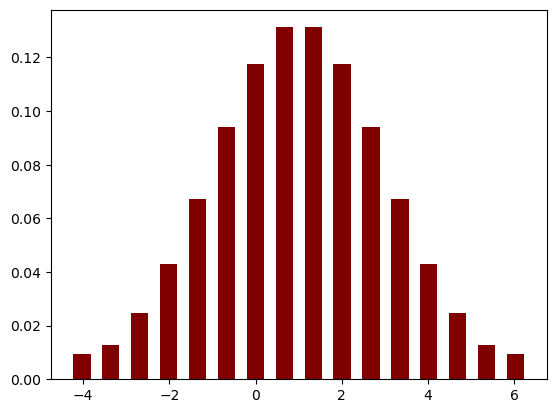

In [70]:
plt.bar(knots[3],prob[3], color ='maroon', width=0.4)